In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import random
import datetime as dt
import math
import itertools
from sklearn import preprocessing
from scipy import stats
import collections
from collections import Counter
#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import is_WG_open, is_day
import config_origins_chapter0 as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [3]:
#choose method to run the script on
name_method = 'ML-method'
#name_method = 'TD-method'

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
#initialise parameters
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
pal_ = config.pal_
pal_zone = config.pal_zone
pal_pens = config.pal_pens
dico_pen_ts = config.dico_pen_ts
pal_tracking_system = config.pal_tracking_system
path_extracted_data_cleaning = os.path.join(path_extracted_data,'Cleaning')
path_extracted_data_cleaning_model = os.path.join(path_extracted_data_cleaning,'model')  
path_extracted_data_cleaning_rawvscleaned = os.path.join(path_extracted_data_cleaning,'Raw&Cleaned')  
path_extracted_data_cleaning_rawvscleaned_MLP = os.path.join(path_extracted_data_cleaning_rawvscleaned, 'MLP')
if not os.path.exists(path_extracted_data_cleaning_rawvscleaned_MLP):
    os.makedirs(path_extracted_data_cleaning_rawvscleaned_MLP)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Download data

In [5]:
#var to select hens based on their available tracked days AND to find the estiamted number of transitions
#Note: this dataset ccontain the variable estimates for the processed and unprocessed dataset
df_var = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, name_method+'_daily_ALL_variables.csv'), sep=';', 
                     parse_dates=['level'], dayfirst=True) 
print(df_var.shape)
df_var['tracking_system'] = df_var['PenID'].map(lambda x: dico_pen_ts[x])
df_var['PenID'] = df_var['PenID'].map(lambda x: 'Pen '+str(int(x)))
#keep days with same artificial light (not that due to technical issue, sometimes we loose few hours on specific days for 
#some animals, thus we will remove these)
df_var = df_var[df_var['verification_daily_total_duration']==54000]
#remove the two dates with irregular WG openeing schedule:
li_date2remove = [dt.datetime(2021,1,4), dt.datetime(2020,11,13)] #first one already not here due to health assessment
df_var = df_var[~df_var['level'].isin(li_date2remove)]
#keep hens with at least 54 days (55 drop from 140 to 90)
df_henselection = df_var.groupby('HenID')['level'].agg(lambda x: len(set(x))).reset_index() #set as cleaning & raw
print(df_henselection['level'].value_counts())
#we choose that all use hens have approxiamely same amount of observations, otherwise if a hen have only 9 days, it will 
#sometims acount as much as another hen having 54 days
df_henselection['has_more_54_days'] = df_henselection['level'].map(lambda x: x>=54)
df_henselection['has_more_54_days'].value_counts()
li_hen_2keep = df_henselection[df_henselection['has_more_54_days']]['HenID'].unique()
print((len(li_hen_2keep)))
df_var = df_var[df_var['HenID'].isin(li_hen_2keep)]
print(df_var.shape)
print('You are analysing %d days, starting at: %s until: %s, with %d hens'%(len(df_var['level'].unique()), 
                                                              str(df_var['level'].min()), 
                                                              str(df_var['level'].max()),
                                                              len(df_var['HenID'].unique())))
df_var.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(19992, 132)
56    86
54    53
9     16
46     9
44     6
47     2
55     1
45     1
16     1
6      1
5      1
Name: level, dtype: int64
140
(15466, 133)
You are analysing 56 days, starting at: 2020-11-14 00:00:00 until: 2021-01-11 00:00:00, with 140 hens


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,dur_values,dur_values_normalized,...,temperature_night20_2_median,temperature_night20_2_max,temperature_night20_2_var,list_of_MovementCounter_day,len_MovementCounter_day,MovementCounter_day_amount_nnactivity,MovementCounter_day_max,MovementCounter_day_mean,type,tracking_system
1,hen_131,2020-11-14,405.0,17084.0,23716.0,2512.0,10283.0,54000.0,"[405.0, 17084.0, 23716.0, 2512.0, 10283.0]","[0.0075, 0.31637037037037036, 0.43918518518518...",...,26.0,28.0,0.750000,"[14.0, 69.0, 47.0, 79.0, 50.0, 46.0, 64.0, 75....",90.0,0.011111,95.0,59.077778,cleaning,TrackingSystem 10-12
2,hen_131,2020-11-15,0.0,16576.0,28684.0,2187.0,6553.0,54000.0,"[0.0, 16576.0, 28684.0, 2187.0, 6553.0]","[0.0, 0.30696296296296294, 0.5311851851851852,...",...,28.0,29.0,0.098765,"[16.0, 70.0, 57.0, 55.0, 60.0, 65.0, 73.0, 73....",90.0,0.033333,91.0,57.922222,cleaning,TrackingSystem 10-12
3,hen_131,2020-11-16,0.0,14508.0,29621.0,3091.0,6780.0,54000.0,"[0.0, 14508.0, 29621.0, 3091.0, 6780.0]","[0.0, 0.26866666666666666, 0.548537037037037, ...",...,27.0,28.0,0.693673,"[64.0, 23.0, 75.0, 52.0, 75.0, 48.0, 52.0, 58....",90.0,0.022222,94.0,54.944444,cleaning,TrackingSystem 10-12


In [6]:
#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

(7293, 13)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


In [7]:
#prediction per records
df_pred = pd.read_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned, id_run+name_method+'_Rawdata&Model.csv'), sep=';', 
                 parse_dates=['Timestamp','date'], dayfirst=True)
df_pred.rename(columns={'Trackingsystem_Zone':'Zone'}, inplace=True)
#add when WG is open and select only during the day when wg is open
df_pred['is_WG_open'] = df_pred['Timestamp'].map(lambda x: x.hour in [10,11,12,13,14,15])
df_pred['is_day'] = df_pred['Timestamp'].map(lambda x: is_day(x,config.dico_night_hour))
df_pred = df_pred[df_pred['HenID'].isin(li_hen_2keep)]
df_pred = df_pred.sort_values('Timestamp') 
df_pred.rename(columns={'date':'level'}, inplace=True)
print(df_pred.shape)
display(df_pred.head(3))
print(min(df_pred['Timestamp']), max(df_pred['Timestamp']))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1419185, 9)


,HenID,PenID,system,Zone,prediction,Timestamp,level,is_WG_open,is_day
0,hen_19,pen9,8 - 9,4_Zone,1,2020-11-13 00:12:06,2020-11-13,False,False
1,hen_19,pen9,8 - 9,5_Zone,1,2020-11-13 00:12:27,2020-11-13,False,False
2,hen_19,pen9,8 - 9,4_Zone,0,2020-11-13 00:13:30,2020-11-13,False,False


2020-11-13 00:12:06 2021-01-11 23:58:59


In [8]:
#keep only when tags was functioning (i.e. when we computed the var)
print(df_pred.shape, df_var.shape)
df_pred = pd.merge(df_pred, df_var[df_var['type']=='cleaning'][['HenID', 'level','verification_daily_total_duration']], 
                    on=['level','HenID'], how='left')
df_pred = df_pred[~df_pred['verification_daily_total_duration'].isnull()]
print(df_pred.shape)
df_pred.head(3)

(1419185, 9) (15466, 133)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1311551, 10)


,HenID,PenID,system,Zone,prediction,Timestamp,level,is_WG_open,is_day,verification_daily_total_duration
20790,hen_140,pen10,10 - 12,5_Zone,0,2020-11-14 00:14:41,2020-11-14,False,False,54000.0
20791,hen_140,pen10,10 - 12,3_Zone,1,2020-11-14 00:14:44,2020-11-14,False,False,54000.0
20792,hen_158,pen8,8 - 9,5_Zone,1,2020-11-14 00:27:54,2020-11-14,False,False,54000.0


In [9]:
df_pred['prediction'].value_counts(normalize=True)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1    0.943514
0    0.056486
Name: prediction, dtype: float64

# Humidity and Temperature - hourly estimated error

In [10]:
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])[['temperature_C', 'humidity_avgpercent']].agg(lambda x: list(x)).reset_index()
df_wday['humidity_avgpercent_avg'] = df_wday['humidity_avgpercent'].map(lambda x: np.mean(x))
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
df_wday

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,temperature_C,humidity_avgpercent,humidity_avgpercent_avg,temperature_C_avg
0,2020-09-29,"[11, 12, 12, 12, 12, 13]","[100, 94, 97, 88, 91, 82]",92.000000,12.000000
1,2020-09-30,"[10, 11, 13, 13, 14, 14]","[88, 82, 77, 75, 75, 75]",78.666667,12.500000
2,2020-10-01,"[13, 15, 15, 15, 15, 14]","[75, 77, 75, 75, 68, 72]",73.666667,14.500000
3,2020-10-02,"[12, 12, 13, 13, 13, 13]","[94, 88, 82, 82, 85, 85]",86.000000,12.666667
4,2020-10-03,"[7, 8, 9, 11, 12, 12]","[93, 90, 79, 76, 63, 65]",77.666667,9.833333
...,...,...,...,...,...
300,2021-07-28,"[18, 19, 20, 20, 21, 22]","[88, 83, 76, 61, 71, 67]",74.333333,20.000000
301,2021-07-29,"[21, 22, 22, 23, 24, 25]","[64, 65, 61, 59, 56, 52]",59.500000,22.833333
302,2021-07-30,"[21, 23, 25, 25, 23, 22]","[69, 65, 58, 58, 78, 78]",67.666667,23.166667
303,2021-07-31,"[20, 21, 22, 22, 22, 22]","[69, 62, 69, 62, 61, 61]",64.000000,21.500000


In [11]:
#merge it to the corresponding (closest) Timestamp and keep only when the WG is open and only the WG registration
#only when WG is open, and only WG registrations (as we have externa weather conditions, not internal, internal is control by
#the barn automatically)
df_pred_weather = pd.merge_asof(df_pred, df_weather_h, on='Timestamp')
df_pred_weather['hour'] = df_pred_weather['Timestamp'].map(lambda x: x.hour)
display(df_pred_weather.tail(3))
df_pred_weather = df_pred_weather[(df_pred_weather['Zone']=='1_Zone') & (df_pred_weather['is_WG_open'])]
print(df_pred_weather.shape)
df_pred_weather[['temperature_C', 'humidity_avgpercent','hour','PenID','Timestamp_weather']].head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,PenID,system,Zone,prediction,Timestamp,level,is_WG_open,is_day,verification_daily_total_duration,...,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather,date
1311548,hen_101,pen5,3 - 5,5_Zone,1,2021-01-11 23:58:54,2021-01-11,False,False,54000.0,...,"no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,2021-01-11
1311549,hen_124,pen8,8 - 9,3_Zone,1,2021-01-11 23:58:56,2021-01-11,False,False,54000.0,...,"no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,2021-01-11
1311550,hen_124,pen8,8 - 9,2_Zone,1,2021-01-11 23:58:59,2021-01-11,False,False,54000.0,...,"no precipitation\n(11:00 pm CET | Monday, Janu...","Moon Phase calculatorJanuary 11, 2021 23h",| waning crescent moon\n2.18% illuminated,23,-7,1,96,no precipitation,2021-01-11 23:00:00,2021-01-11


(22868, 23)


,temperature_C,humidity_avgpercent,hour,PenID,Timestamp_weather
8946,7,91,10,pen8,2020-11-14 10:00:00
8989,7,91,10,pen4,2020-11-14 10:00:00
8994,7,91,10,pen4,2020-11-14 10:00:00


In [12]:
df_quantitatif_weather = df_pred_weather.groupby(['Timestamp_weather','PenID','hour','system'])[['prediction','temperature_C',
                                                            'humidity_avgpercent']].agg(lambda x: list(x)).reset_index()
df_quantitatif_weather['humidity_avgpercent'] = df_quantitatif_weather['humidity_avgpercent'].map(lambda x: x[0])
df_quantitatif_weather['temperature_C'] = df_quantitatif_weather['temperature_C'].map(lambda x: x[0])
df_quantitatif_weather['IFR'] = df_quantitatif_weather['prediction'].map(lambda x: len(x)-sum(x))
df_quantitatif_weather['nbr registrations'] = df_quantitatif_weather['prediction'].map(lambda x: len(x))
df_quantitatif_weather['estimated error rate'] = df_quantitatif_weather.apply(lambda x: x['IFR']/x['nbr registrations'], axis=1)
df_quantitatif_weather['estimated transitions'] = df_quantitatif_weather['prediction'].agg(lambda x: sum(x))
#print(df_quantitatif_weather.shape)
#df_quantitatif_weather = df_quantitatif_weather[df_quantitatif_weather['nbr registrations']>5] #does not chagne results
print(df_quantitatif_weather.shape)
df_quantitatif_weather = df_quantitatif_weather[df_quantitatif_weather['hour']!=17]
print(df_quantitatif_weather.shape)
display(df_quantitatif_weather.head(3))
df_quantitatif_weather.to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                               'environmentalfactorestimatederrorrate.csv'), index=False, sep=';')
#sns.histplot(df_quantitatif_weather, x='estimated error rate');
#sns.histplot(df_quantitatif_weather,x='nbr registrations');

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(2614, 11)
(2614, 11)


,Timestamp_weather,PenID,hour,system,prediction,temperature_C,humidity_avgpercent,IFR,nbr registrations,estimated error rate,estimated transitions
0,2020-11-14 10:00:00,pen10,10,10 - 12,"[1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]",7,91,2,15,0.133333,13
1,2020-11-14 10:00:00,pen11,10,10 - 12,"[1, 1, 0, 1, 1, 1]",7,91,1,6,0.166667,5
2,2020-11-14 10:00:00,pen12,10,10 - 12,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]",7,91,1,12,0.083333,11


## Estimated error within pen-zone areas

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PenID,Zone,HenID,prediction
0,pen10,1_Zone,hen_131,0.079498
1,pen10,1_Zone,hen_134,0.112179
2,pen10,1_Zone,hen_138,0.068627


,PenID,Trackingsystem_Zone,estimated error rate
0,pen10,1_Zone,"[0.0794979079497908, 0.11217948717948718, 0.06..."
1,pen10,2_Zone,"[0.0014374700527072352, 0.0, 0.001141552511415..."
2,pen10,3_Zone,"[0.03220151319431629, 0.10213243546576879, 0.0..."


,PenID,Trackingsystem_Zone,estimated error rate,stddev,mean,annot
0,pen10,1_Zone,"[0.0794979079497908, 0.11217948717948718, 0.06...",0.221221,0.136814,0.14 \n +/-0.22
1,pen10,2_Zone,"[0.0014374700527072352, 0.0, 0.001141552511415...",0.000585,0.000706,0.0 \n +/-0.0
2,pen10,3_Zone,"[0.03220151319431629, 0.10213243546576879, 0.0...",0.031983,0.071258,0.07 \n +/-0.03


annotations:


Trackingsystem_Zone,1_Zone,2_Zone,3_Zone,4_Zone,5_Zone
PenID,,,,,
pen10,0.14 \n +/-0.22,0.0 \n +/-0.0,0.07 \n +/-0.03,0.06 \n +/-0.11,0.15 \n +/-0.11
pen11,0.11 \n +/-0.06,0.0 \n +/-0.0,0.01 \n +/-0.01,0.01 \n +/-0.03,0.11 \n +/-0.13
pen12,0.07 \n +/-0.04,0.0 \n +/-0.0,0.06 \n +/-0.03,0.04 \n +/-0.05,0.16 \n +/-0.15
pen3,0.12 \n +/-0.13,0.04 \n +/-0.02,0.11 \n +/-0.06,0.05 \n +/-0.07,0.06 \n +/-0.1
pen4,0.15 \n +/-0.22,0.05 \n +/-0.04,0.08 \n +/-0.03,0.3 \n +/-0.19,0.0 \n +/-0.01
pen5,0.16 \n +/-0.23,0.01 \n +/-0.01,0.06 \n +/-0.08,0.03 \n +/-0.05,0.01 \n +/-0.01
pen8,0.5 \n +/-0.19,0.0 \n +/-0.01,0.01 \n +/-0.01,0.17 \n +/-0.17,0.09 \n +/-0.08
pen9,0.44 \n +/-0.11,0.02 \n +/-0.03,0.02 \n +/-0.02,0.27 \n +/-0.2,0.17 \n +/-0.13


values:


Trackingsystem_Zone,1_Zone,2_Zone,3_Zone,4_Zone,5_Zone
PenID,,,,,
pen10,0.136814,0.000706,0.071258,0.055269,0.152713
pen11,0.111358,0.000059,0.009595,0.010336,0.109168
pen12,0.068969,0.000806,0.055518,0.035906,0.158858
pen3,0.115245,0.035195,0.111171,0.053050,0.057579
pen4,0.148196,0.046003,0.083935,0.300341,0.003732
pen5,0.159839,0.007302,0.061448,0.032160,0.010527
pen8,0.500135,0.004212,0.012972,0.172519,0.094345
pen9,0.444529,0.019626,0.024850,0.271889,0.169283


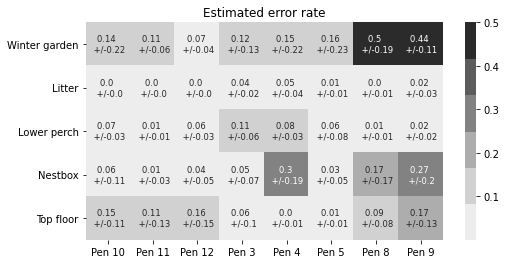

In [13]:
#computing per animal and taking the mean +-std deviation
#IRF/nbr registrations = estimated error rate
#all except zone 1 when wg is close (important to keep nights for nestboxes!) and nights as may be other factors there. We only
#are studying the days
df_quantitatif = df_pred[~((~df_pred['is_WG_open'])&(df_pred['Zone']=='1_Zone')) & (df_pred['is_day'])].groupby(['PenID','Zone','HenID'])['prediction'].agg(lambda x: (len(x)-sum(x))/len(x)).reset_index()
display(df_quantitatif.head(3))
df_quantitatif = df_quantitatif.groupby(['PenID','Zone'])['prediction'].agg(lambda x: list(x)).reset_index()
df_quantitatif.rename(columns={'prediction':'estimated error rate','Zone':'Trackingsystem_Zone'}, inplace=True)
display(df_quantitatif.head(3))
#mean and std over hens
df_quantitatif['stddev'] = df_quantitatif['estimated error rate'].map(lambda x: np.std(x)) #not IC as not normally distrib.
df_quantitatif['mean'] = df_quantitatif['estimated error rate'].map(lambda x: np.mean(x))
df_quantitatif['annot'] = df_quantitatif.apply(lambda x: str(round(x['mean'],2))+' \n +/-'+str(round(x['stddev'],2)), axis=1)
display(df_quantitatif.head(3))
#annotations
df_annot = df_quantitatif.pivot(values='annot',index='PenID',columns='Trackingsystem_Zone')
print('annotations:')
display(df_annot)
annot_mean_std = df_annot.to_numpy()
#values
df_quantitatif = df_quantitatif.pivot(values='mean',index='PenID',columns='Trackingsystem_Zone')
print('values:')
display(df_quantitatif)
M = df_quantitatif.to_numpy()
dico_x_name = {'1_Zone':'Winter garden',
               '2_Zone':'Litter',
               '3_Zone':'Lower perch',
               '4_Zone':'Nestbox',
               '5_Zone':'Top floor'}
dico_pen_name = {'pen3':'Pen 3',
               'pen4':'Pen 4',
               'pen5':'Pen 5',
               'pen6':'Pen 6',
               'pen8':'Pen 8',
               'pen9':'Pen 9',
               'pen10':'Pen 10',
               'pen11':'Pen 11',
               'pen12':'Pen 12'}
plt.figure(figsize=(8,4))
sns.heatmap(M.transpose(), xticklabels=[dico_pen_name[x] for x in df_quantitatif.index.tolist()], 
            yticklabels=[dico_x_name[x] for x in df_quantitatif.columns.tolist()], cmap=sns.color_palette("Greys"),
            annot=annot_mean_std.transpose(), fmt='', annot_kws={"size":8.4})
plt.title(r'Estimated error rate')
plt.savefig(os.path.join(path_extracted_data_cleaning_rawvscleaned, 'EER_ZonePerPen.png'),format='png',dpi=300,
           bbox_inches='tight')
plt.show()

# amount of transitions

In [14]:
def nbr_transition(li):
    '''function to compute number of transition from list of consecutives zone name'''
    return max(len(list(itertools.groupby(li, lambda x: x)))-1,0) #max in case of empty list
#small test
#t = [1,1,1,1,2,2,2,3,3,3,4,4,2,2,2,2]
#print(nbr_transition(t)) #4

#only when WG is open to have full barn access
df_pred_ = df_pred[df_pred['is_WG_open']].copy()
#unprocessed
df_tr = df_pred_.groupby(['HenID','level'])['Zone'].agg(lambda x: nbr_transition(list(x))).reset_index()
df_tr.rename(columns={'Zone':'Unprocessed_number_transition'}, inplace=True)
display(df_tr.head(3))

#unproc
df_estiamtedtr = df_pred_[df_pred_['prediction']==1].groupby(['HenID','level'])['Zone'].agg(lambda x: nbr_transition(list(x))).reset_index()
df_estiamtedtr.rename(columns={'Zone':'Estimated_number_transition'}, inplace=True)
display(df_estiamtedtr.head(3))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,Unprocessed_number_transition
0,hen_1,2020-11-14,33
1,hen_1,2020-11-15,26
2,hen_1,2020-11-16,26


,HenID,level,Estimated_number_transition
0,hen_1,2020-11-14,33
1,hen_1,2020-11-15,22
2,hen_1,2020-11-16,24


In [15]:
#merge processed and unnprocessed amount of transitions per day
df_trall = pd.merge(df_estiamtedtr, df_tr, on=['HenID','level'])
print(df_estiamtedtr.shape, df_tr.shape, df_trall.shape)
df_trall.head(3)

(7485, 3) (7485, 3) (7485, 4)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,Estimated_number_transition,Unprocessed_number_transition
0,hen_1,2020-11-14,33,33
1,hen_1,2020-11-15,22,26
2,hen_1,2020-11-16,24,26


In [16]:
#all zones are linked: an error in one induce an error in another. we will here look if the overall nbr of estimated correct 
#registrations is linked with the estimated error rate
#to keep all zones and everything equal, we will only look while the WG is open: i.e the full pen is available for the birds
df_transitionlevel = df_pred_.groupby(['HenID','PenID','system','level'])['prediction'].agg(lambda x: list(x)).reset_index()
df_transitionlevel['IFR'] = df_transitionlevel['prediction'].map(lambda x: len(x)-sum(x))
df_transitionlevel['nbr registrations'] = df_transitionlevel['prediction'].map(lambda x: len(x))
df_transitionlevel['EER'] = df_transitionlevel.apply(lambda x: x['IFR']/x['nbr registrations'], axis=1)
#add estimated number of transitions over that day per bird
df_transitionlevel = pd.merge(df_transitionlevel, df_trall, on=['level','HenID'], how='left')
df_transitionlevel.to_csv(os.path.join(path_extracted_data_cleaning_rawvscleaned,
                                               'estimatednumbertransitionsestimatederrorrate.csv'), index=False, sep=';')
print(df_transitionlevel.shape)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(7485, 10)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


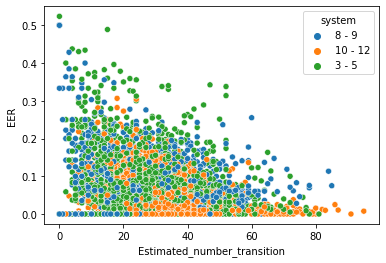

In [17]:
sns.scatterplot(x='Estimated_number_transition', y='EER', data=df_transitionlevel, hue='system');

In [18]:
#df_pred[(df_pred['HenID']=='hen_1')&(df_pred['level']==dt.datetime(2020,11,14))].iloc[0:25]

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df_transitionlevel.groupby(['system','PenID'])['HenID'].agg(lambda x: len(set(x))).reset_index()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,system,PenID,HenID
0,10 - 12,pen10,18
1,10 - 12,pen11,18
2,10 - 12,pen12,17
3,3 - 5,pen3,18
4,3 - 5,pen4,18
5,3 - 5,pen5,17
6,8 - 9,pen8,16
7,8 - 9,pen9,18
